# Paper Figures
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 1/28/2022|

In [3]:
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
# import pandas as pd
from scipy import fftpack
from scipy.optimize import curve_fit

dpi = 300 # PDF resolution (dots per inch)
# pwd = '../unstrat/'
pwd = '../nonlinear/Pi/'

## DDD

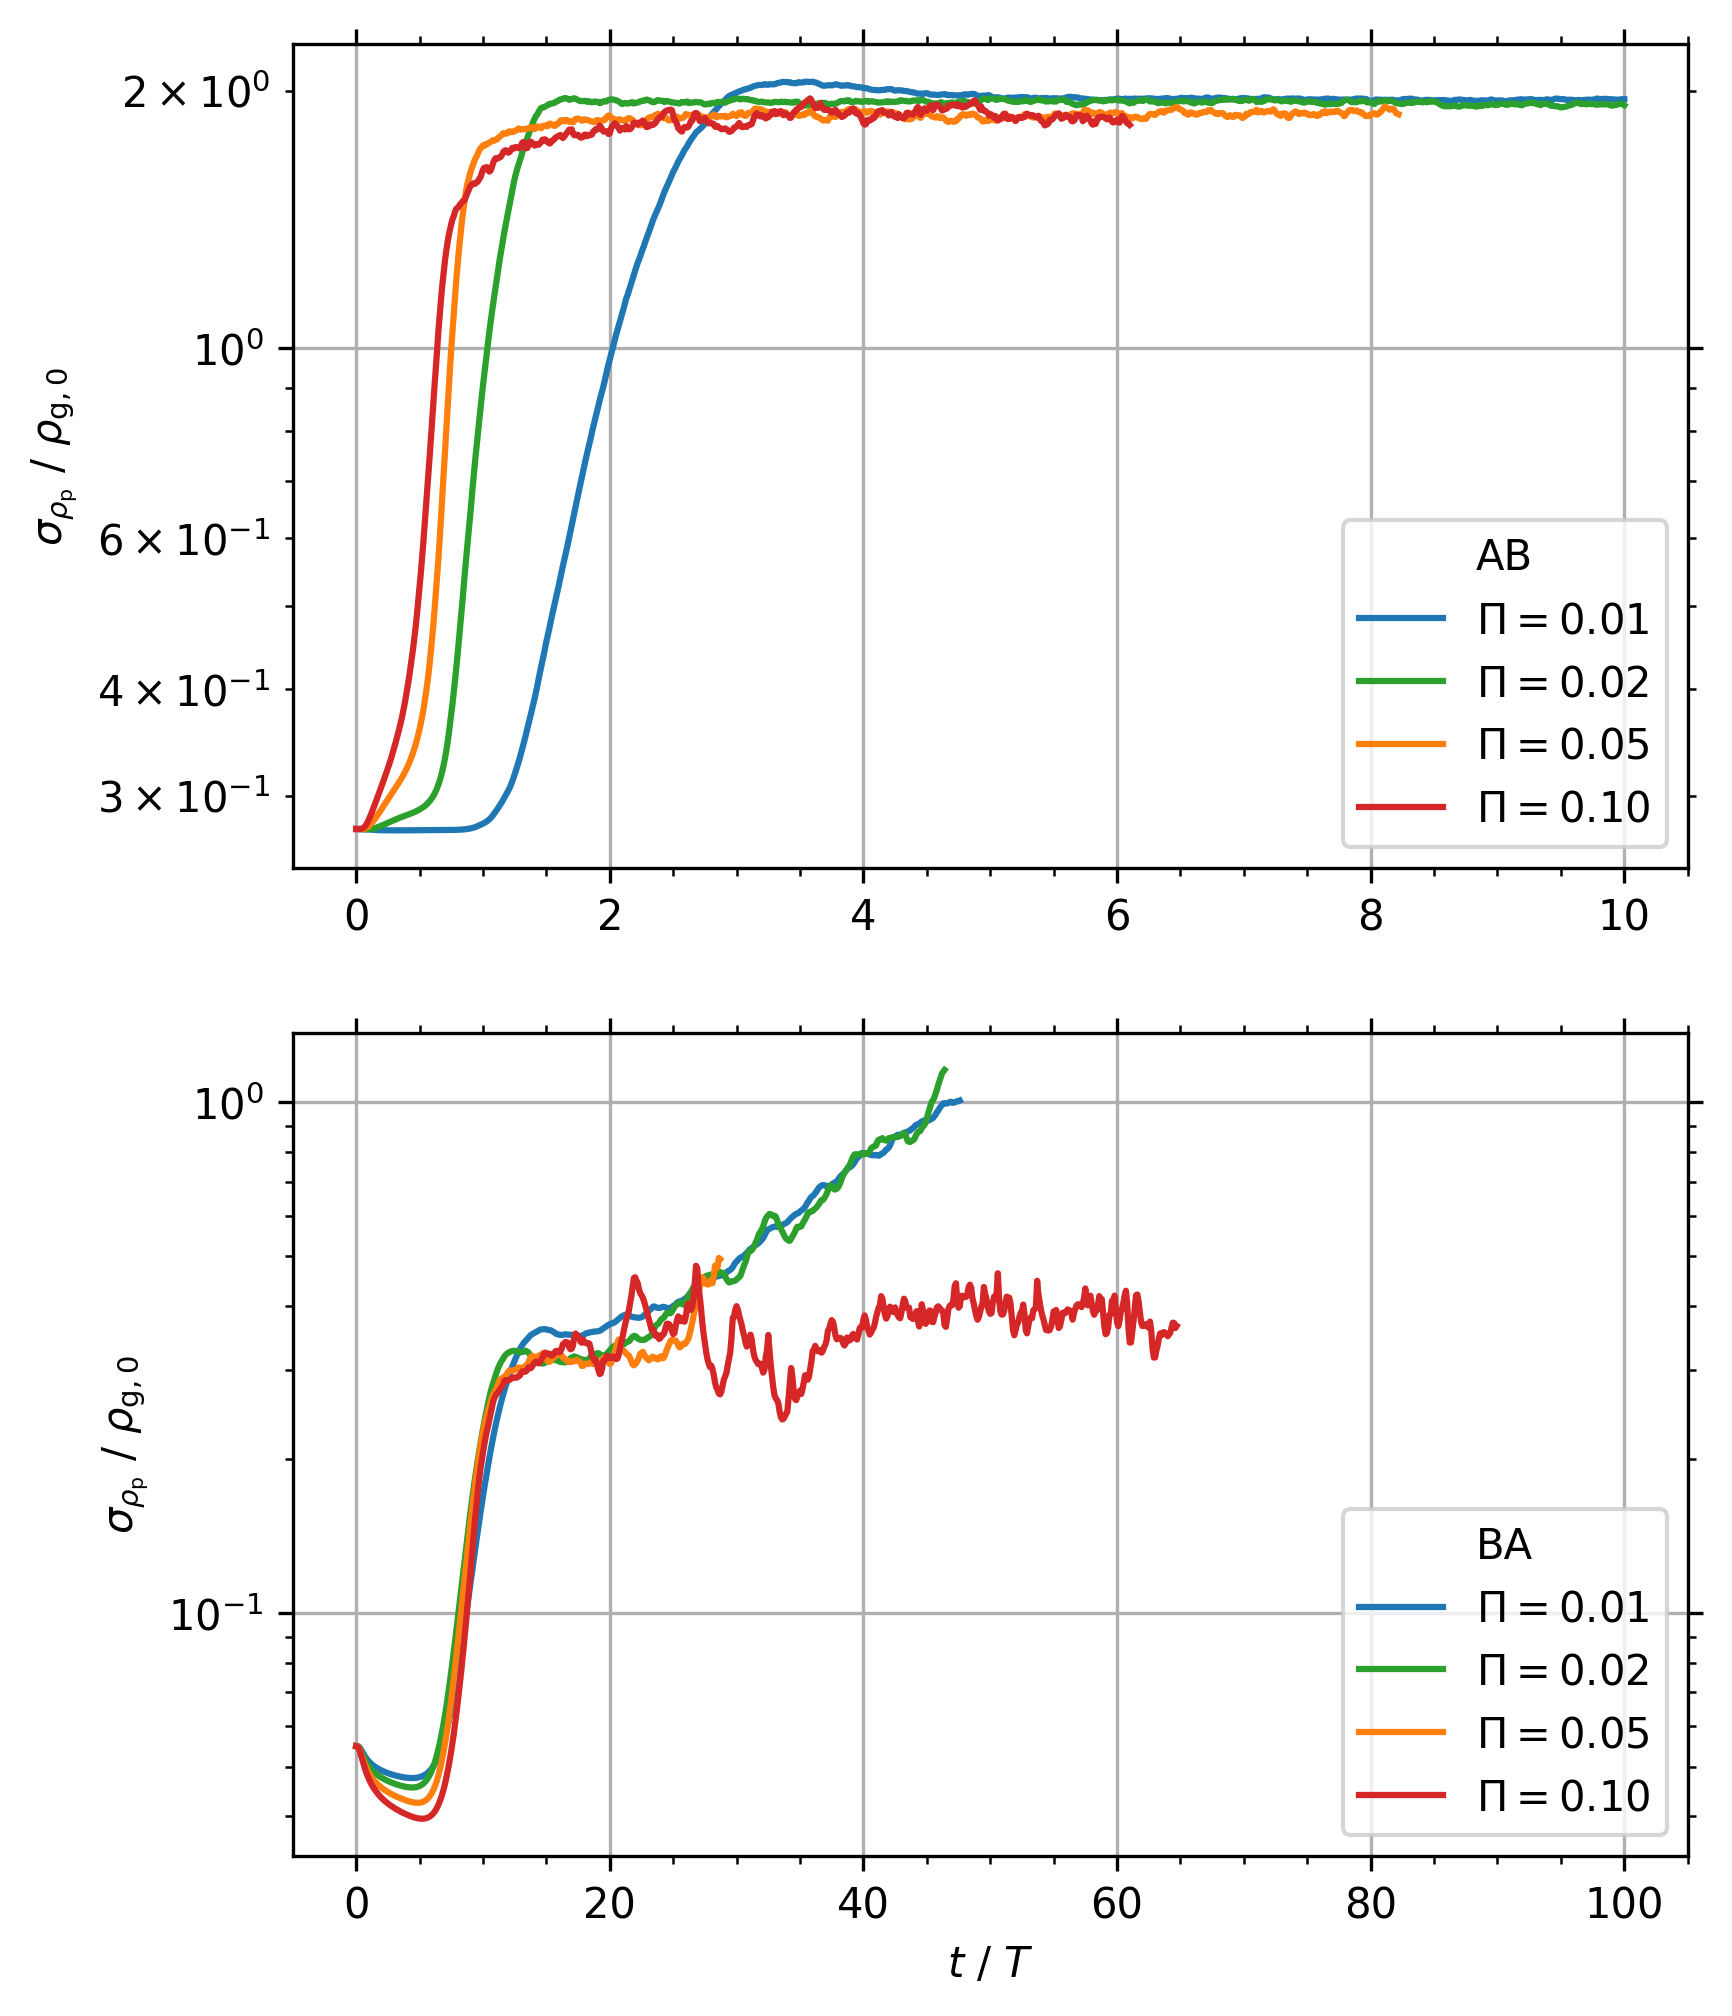

In [2]:
fig, axs = plt.subplots(2, 1, figsize=(6,8), dpi=dpi)
runs = ['AB', 'BA']
Pis = [['0.01', 'tab:blue'], ['0.02', 'tab:green'],
       ['0.05', 'tab:orange'], ['0.10', 'tab:red']]
res = '2048'
xlims = [(-0.5, 10.5), (-5, 105)] # remove for final

for i,run in enumerate(runs):
    for Pi in Pis:
        hst = athena_read.hst(pwd+'%s/%s/%s/output/SI.hst'\
                              %(run, Pi[0], res))
        times = hst['time']
        rhop_amps = np.sqrt(hst['drhop2'] - hst['drhop']**2)
        axs[i].semilogy(times, rhop_amps, color=Pi[1], label=r'$\Pi=$'+Pi[0])
    axs[i].grid()
    axs[i].legend(loc='lower right', title=run)
    axs[i].minorticks_on()
    axs[i].set(ylabel=r'$\sigma_{\rho_\mathrm{p}}$ / $\rho_\mathrm{g,0}$')
    axs[i].tick_params(which='both', top=True, right=True)
    axs[i].set_xlim(xlims[i]) # remove for final

axs[1].set(xlabel=r'$t$ / $T$')
plt.savefig('figs/ddd.pdf', bbox_inches='tight', pad_inches=0.01)

## CPDD

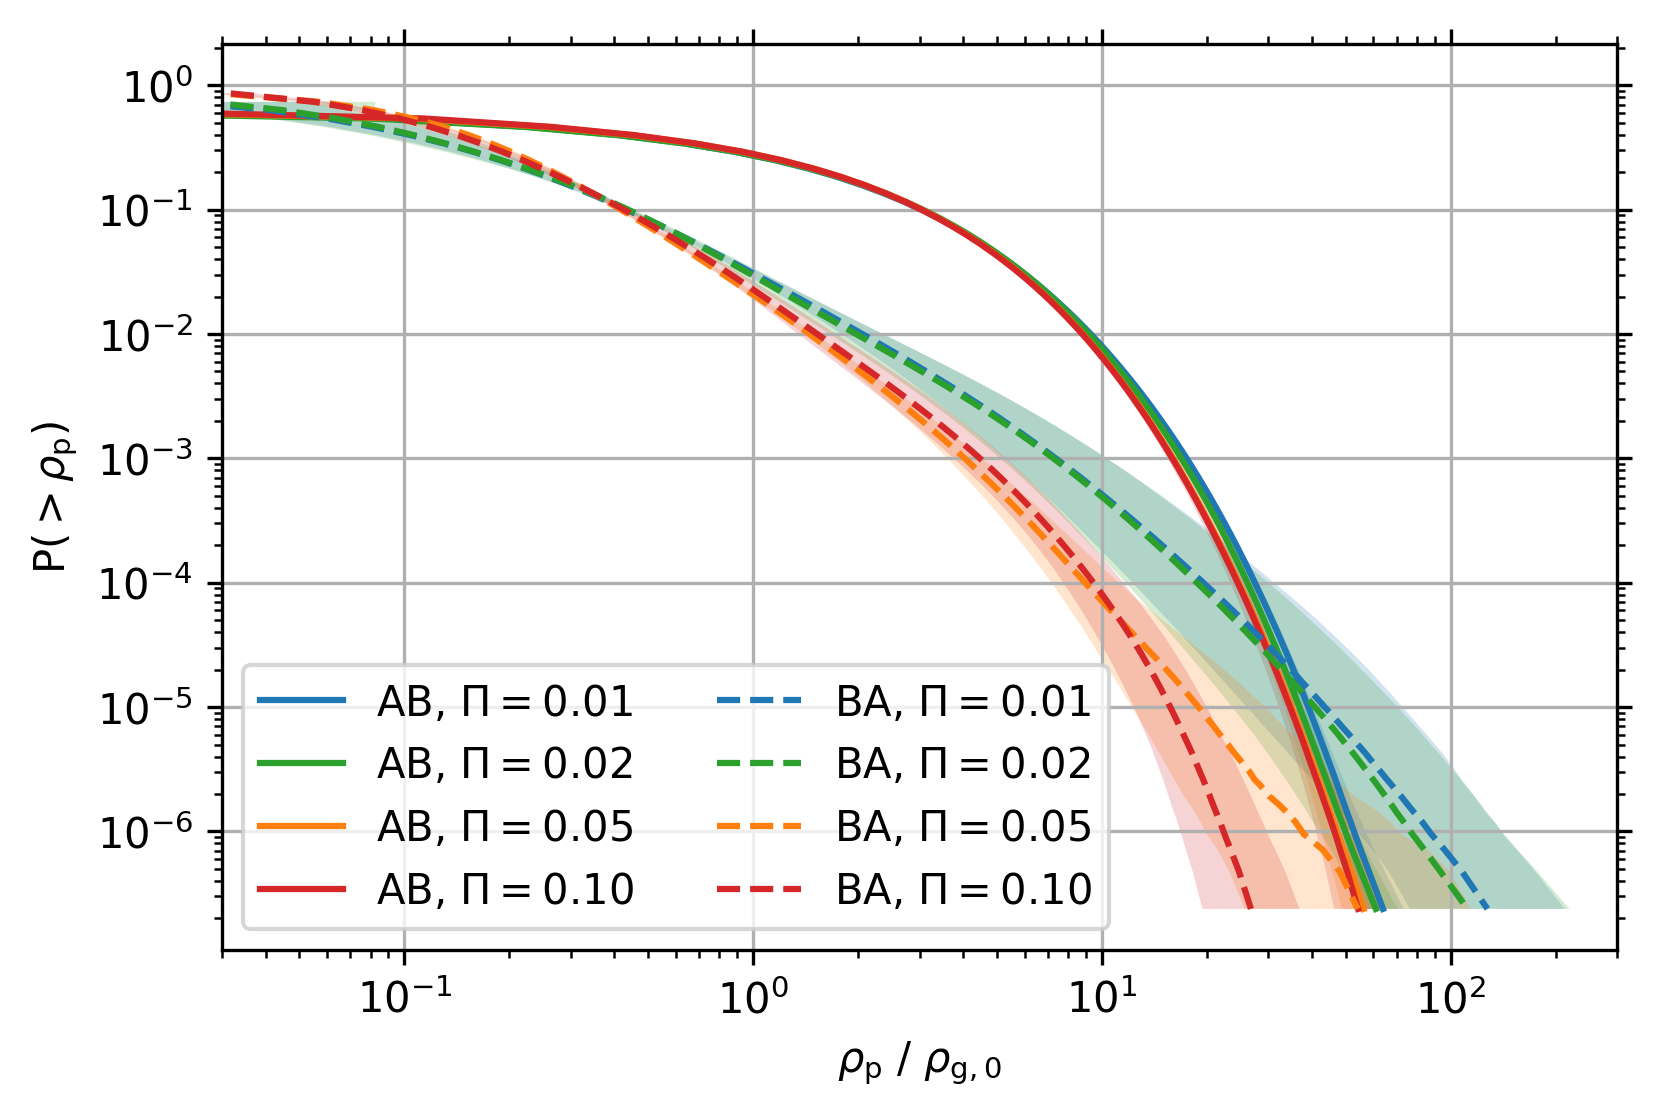

In [6]:
fig, ax = plt.subplots(dpi=dpi)
runs = [['AB', 'solid', 1.0], ['BA', 'dashed', 0.2]]
Pis = [['0.01', 'tab:blue'], ['0.02', 'tab:green'],
       ['0.05', 'tab:orange'], ['0.10', 'tab:red']]
res = '2048'
indices = -np.unique(np.logspace(np.log2(int(res)**2), 0, num=100,
                     base=2, dtype=int))

for run in runs:
    for Pi in Pis:
        with np.load(pwd+'%s/%s/%s/output/cpdd.npz'\
                     %(run[0], Pi[0], res)) as data:
            avgs = np.flip(np.take_along_axis(data['avgs'], indices, 0))
            cdf = np.flip(np.take_along_axis(data['cdf'], indices, 0))
            stds = np.flip(np.take_along_axis(data['stds'], indices, 0))
            ax.loglog(run[2]*avgs, cdf, color=Pi[1], ls=run[1],
                      label=run[0]+r', $\Pi=$'+Pi[0])
            ax.fill_betweenx(cdf, run[2]*avgs/stds, run[2]*avgs*stds,
                             color=Pi[1], ec=None, alpha=0.2)

ax.grid()
ax.legend(ncol=2)
ax.minorticks_on()
ax.set(xlim=(0.03, 3e2), ylabel=r'P$(>\rho_\mathrm{p})$',
       xlabel=r'$\rho_\mathrm{p}$ / $\rho_\mathrm{g,0}$')
ax.tick_params(which='both', top=True, right=True)
plt.savefig('figs/cpdd.pdf', bbox_inches='tight', pad_inches=0.01)

## Turbulent Gas Mach Numbers

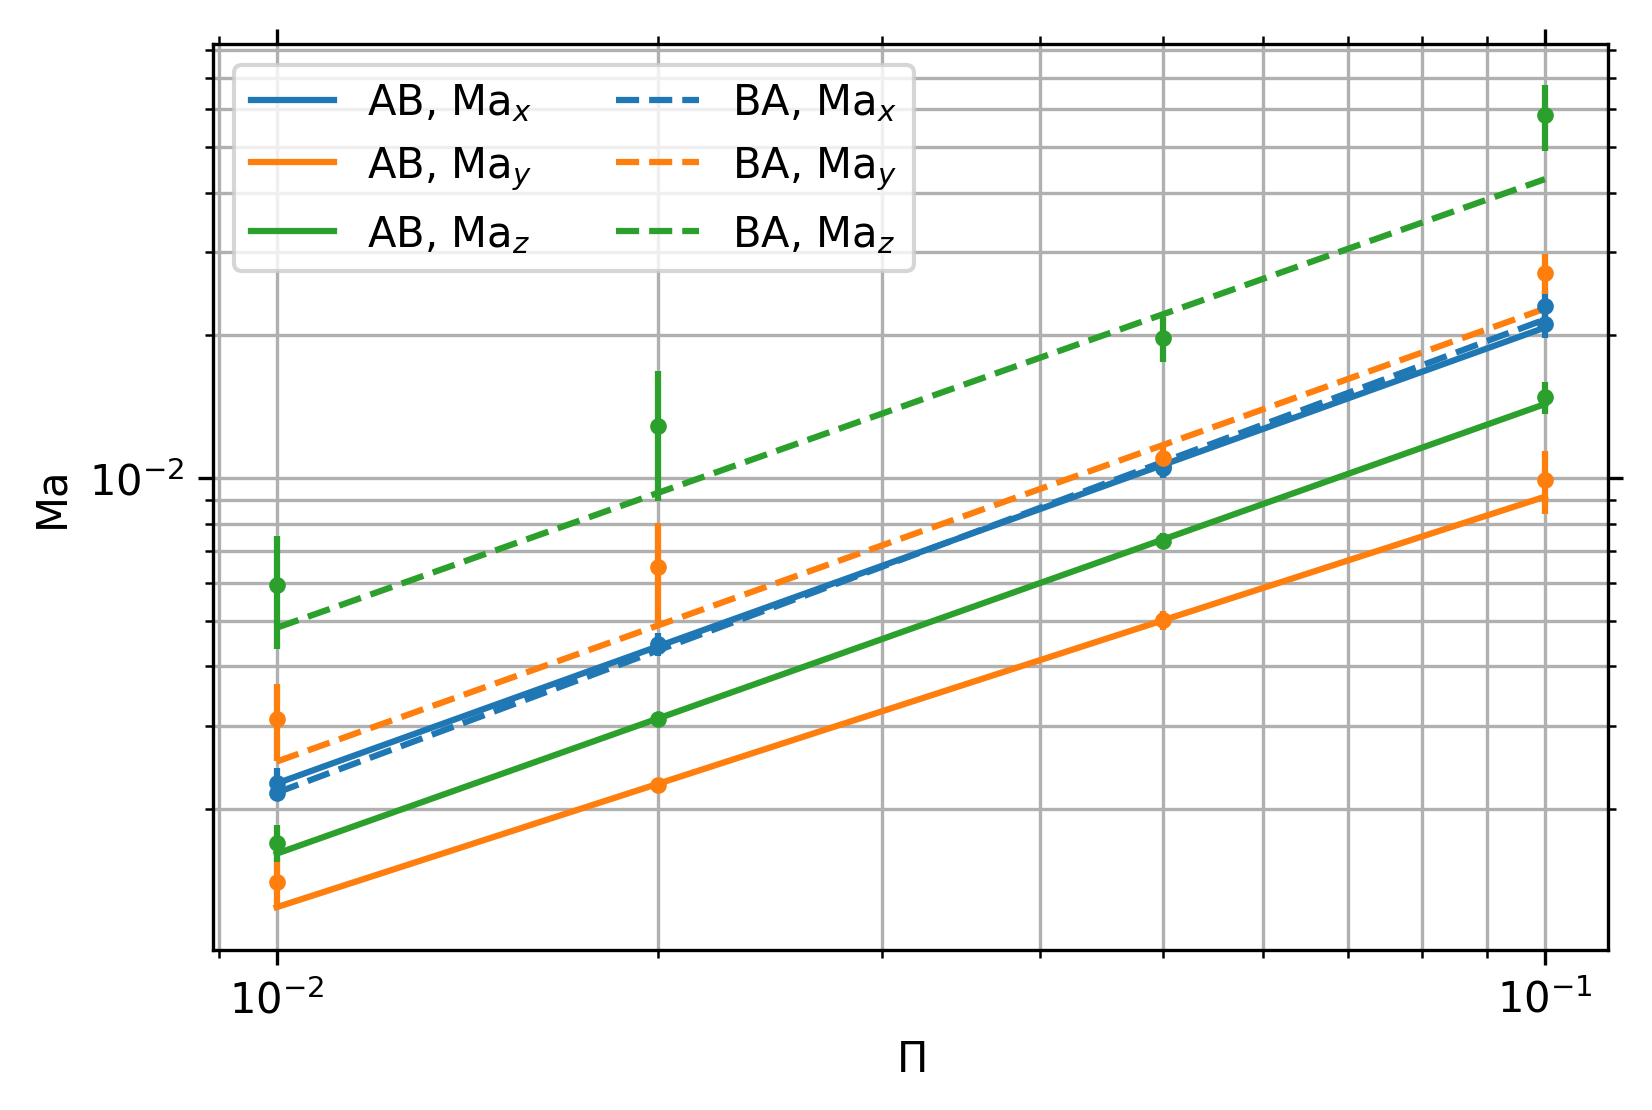

In [4]:
fig, ax = plt.subplots(dpi=dpi)
runs = [['AB', 'solid', 2.0], ['BA', 'dashed', 20.0]]
Pis = [0.01, 0.02, 0.05, 0.10]
res = '2048'
dirs = [['x', 'dux',   'dux2', 1, 'tab:blue'],
        ['y', 'duy',   'duy2', 1, 'tab:orange'],
        ['z', '2-mom', '2-KE', 2, 'tab:green']]
avgMas, stdMas= np.zeros((len(Pis), len(dirs))), np.zeros((len(Pis), len(dirs)))
func = lambda x, a, k : a*x**k # power-law model function
case, modfunc, a, aerr, k, kerr = [], [], [], [], [], []

for run in runs:
    for i,dir in enumerate(dirs):
        for j,Pi in enumerate(Pis):
            path = pwd+'%s/%s/%s/'%(run[0], f'{Pi:0.2f}', res)
            athinput = athena_read.athinput(path+'athinput.si')
            hst = athena_read.hst(path+'output/SI.hst')
            i_sat = int(run[2]/athinput['output3']['dt']) # index of sat. state
            disp = np.sqrt(dir[3]*hst[dir[2]]/hst['mass']-(hst[dir[1]]/hst['mass'])**2)
            Ma = disp/athinput['hydro']['iso_sound_speed']
            avgMas[j,i], stdMas[j,i] = np.average(Ma[i_sat:]), np.std(Ma[i_sat:])
        popt, pcov = curve_fit(func, Pis, avgMas[:,i], sigma=stdMas[:,i])
        perr = np.sqrt(np.diag(pcov))
        label = r'{:s}, Ma$_{:s}$'.format(run[0], dir[0])
        ax.errorbar(Pis, avgMas[:,i], stdMas[:,i], fmt='.', color=dir[4])
        ax.plot(Pis, func(Pis, *popt), ls=run[1], color=dir[4], label=label)
        case.append(run[0]); modfunc.append(f'Ma$_{dir[0]:s}=a\Pi^k$')
        a.append(popt[0]); aerr.append(perr[0])
        k.append(popt[1]); kerr.append(perr[1])

ax.grid(which='both')
ax.legend(ncol=2)
ax.minorticks_on()
ax.set(xlabel=r'$\Pi$', ylabel='Ma', xscale='log', yscale='log')
ax.tick_params(which='both', top=True, right=True)
plt.savefig('figs/machs.pdf', bbox_inches='tight', pad_inches=0.01)

df = pd.DataFrame({
    'Case'       : case,
    'Function'   : modfunc,
    '$a$'        : a,
    '$\sigma_a$' : aerr,
    '$k$'        : k,
    '$\sigma_k$' : kerr,})
s = df.style.format({
    '$a$'        : '{:.2f}',
    '$\sigma_a$' : '{:.3f}',
    '$k$'        : '{:.2f}',
    '$\sigma_k$' : '{:.2f}',})
s.to_latex(buf='tabs/machs.txt')

## Radial Dust Velocities

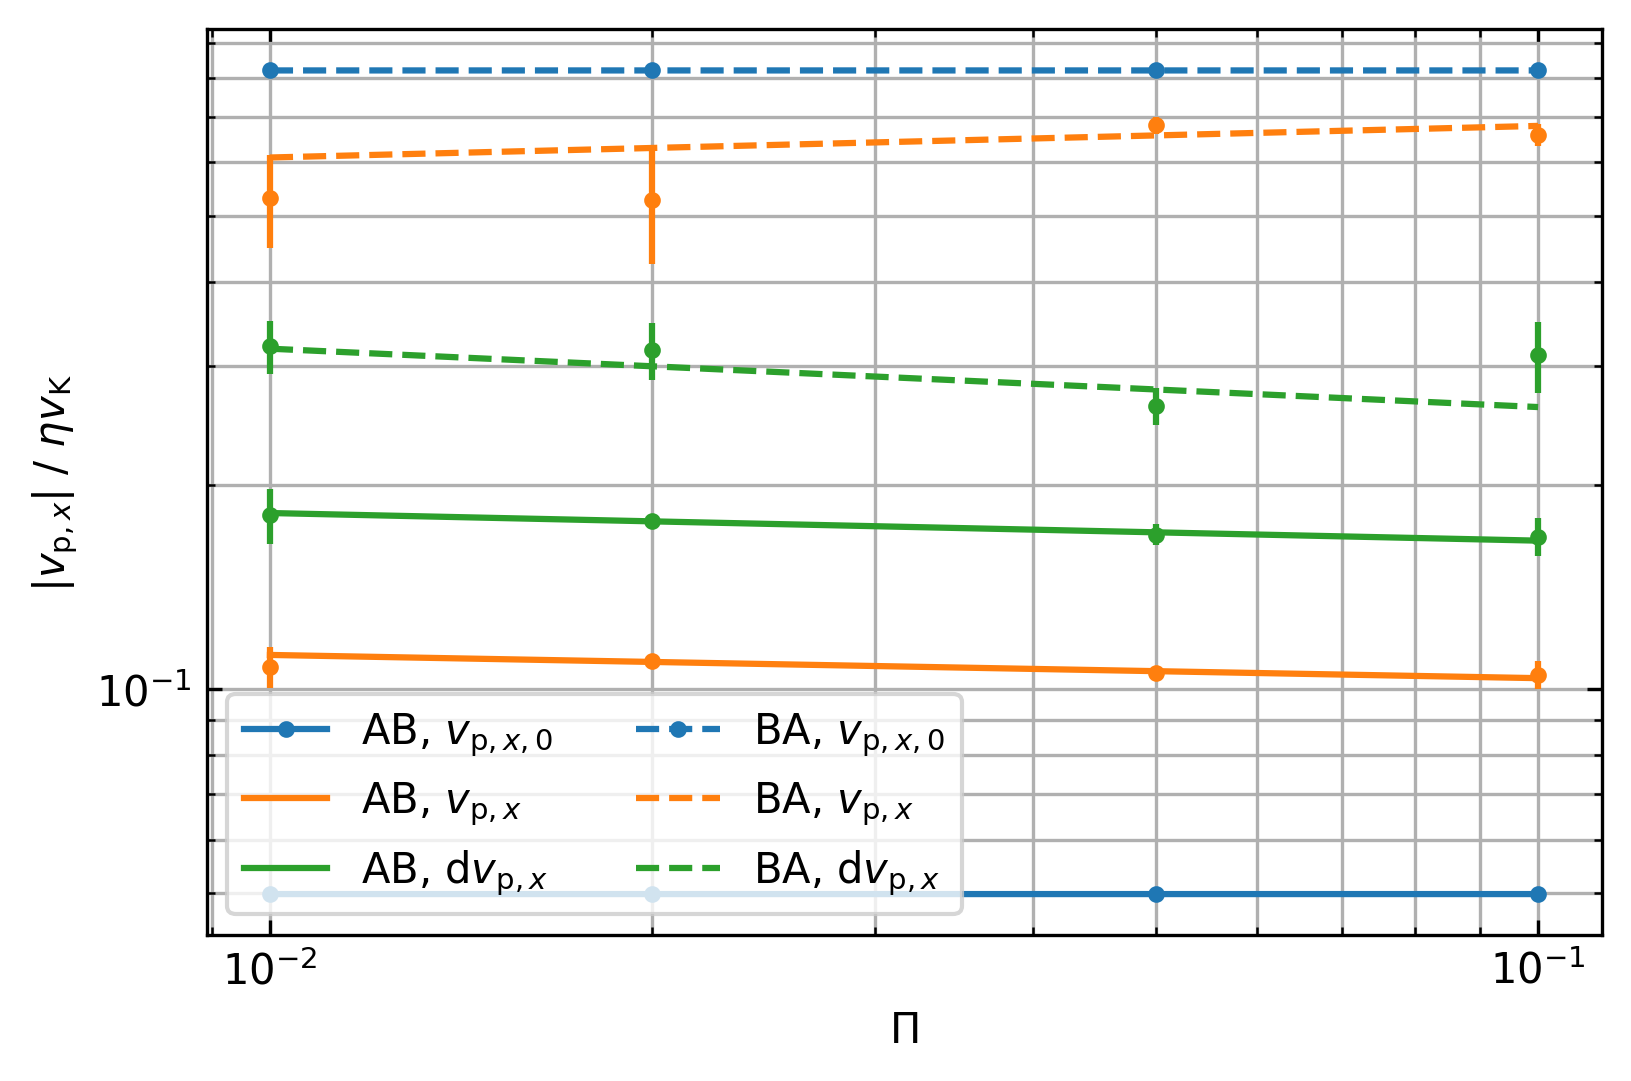

In [7]:
fig, ax = plt.subplots(dpi=dpi)
runs = [['AB', 'solid', 2.0], ['BA', 'dashed', 20.0]]
Pis = [0.01, 0.02, 0.05, 0.10]
res = '2048'
vxs0    = np.zeros((len(runs), len(Pis))) # init. velocities
vxs     = np.zeros((len(runs), len(Pis))) # sat. velocities
stdvxs  = np.zeros((len(runs), len(Pis)))
dvxs    = np.zeros((len(runs), len(Pis))) # vel. dispersion
stddvxs = np.zeros((len(runs), len(Pis))) 
case, modfunc, a, aerr, k, kerr = [], [], [], [], [], []

for i,run in enumerate(runs):
    for j,Pi in enumerate(Pis):
        path = pwd+'%s/%s/%s/'%(run[0], f'{Pi:0.2f}', res)
        athinput = athena_read.athinput(path+'athinput.si')
        hst = athena_read.hst(path+'output/SI.hst')
        i_sat = int(run[2]/athinput['output3']['dt']) # sat. state index
        prob, mesh = athinput['problem'], athinput['mesh']
        Np = prob['npx1']*prob['npx2']*prob['npx3']   # total particles
        Lx = (mesh['x1max'] - mesh['x1min'])
        Ly = (mesh['x3max'] - mesh['x3min'])
        Lz = (mesh['x2max'] - mesh['x2min'])
        V = Lx*Ly*Lz                                  # domain volume / H^3
        epsilon = prob['epsilon']
        etav_K = Pi*athinput['hydro']['iso_sound_speed']
        vxs0[i,j] = hst['vp1'][0]/etav_K/Np
        vxs[i,j] = np.average(hst['vp1'][i_sat:])/etav_K/Np
        stdvxs[i,j] = np.std(hst['vp1'][i_sat:])/etav_K/Np
        disp = np.sqrt(hst['dvpx2']/epsilon/V - (hst['dvpx']/epsilon/V)**2)
        dvxs[i,j] = np.average(disp[i_sat:])/etav_K
        stddvxs[i,j] = np.std(disp[i_sat:])/etav_K
    func = lambda x, a, k : a*x**k # power-law model function
    absvxs, absdvxs = np.abs(vxs[i,:]), np.abs(dvxs[i,:])
    popt, pcov = curve_fit(func, Pis, absvxs, sigma=stdvxs[i,:])
    poptd, pcovd = curve_fit(func, Pis, absdvxs, sigma=stddvxs[i,:])
    perr = np.sqrt(np.diag(pcov))
    perrd = np.sqrt(np.diag(pcovd))
    ax.plot(Pis, np.abs(vxs0[i,:]), marker='.', ls=run[1], color='tab:blue',
            label=run[0]+r', $v_{\mathrm{p},x,0}$')
    ax.errorbar(Pis, absvxs, stdvxs[i,:], fmt='.', color='tab:orange')
    ax.errorbar(Pis, absdvxs, stddvxs[i,:], fmt='.', color='tab:green')
    ax.plot(Pis, func(Pis, *popt), ls=run[1], color='tab:orange',
            label=run[0]+r', $v_{\mathrm{p},x}$')
    ax.plot(Pis, func(Pis, *poptd), ls=run[1], color='tab:green',
            label=run[0]+r', $\mathrm{d}v_{\mathrm{p},x}$')
    case.append(run[0]); modfunc.append(r'$|v_{\mathrm{p},x,0}|=a\Pi^k$')
    a.append(np.abs(vxs0[i,0])); aerr.append(0)
    k.append(0); kerr.append(0)
    case.append(run[0]); modfunc.append(r'$|v_{\mathrm{p},x}|=a\Pi^k$')
    a.append(popt[0]); aerr.append(perr[0])
    k.append(popt[1]); kerr.append(perr[1])
    case.append(run[0]); modfunc.append(r'$\mathrm{d}v_{\mathrm{p},x}=a\Pi^k$')
    a.append(poptd[0]); aerr.append(perrd[0])
    k.append(poptd[1]); kerr.append(perrd[1])

ax.grid(which='both')
ax.legend(ncol=2)
ax.minorticks_on()
ax.set(xlabel=r'$\Pi$', ylabel=r'$|v_{\mathrm{p},x}|$ / $\eta v_\mathrm{K}$',
       xscale='log', yscale='log')#, ylim=(5e-3, 2e0))
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
plt.savefig('figs/vxs.pdf', bbox_inches='tight', pad_inches=0.01)

df = pd.DataFrame({
    'Case'       : case,
    'Function'   : modfunc,
    '$a$'        : a,
    '$\sigma_a$' : aerr,
    '$k$'        : k,
    '$\sigma_k$' : kerr,})
s = df.style.format({
    '$a$'        : '{:.2f}',
    '$\sigma_a$' : '{:.2f}',
    '$k$'        : '{:.2f}',
    '$\sigma_k$' : '{:.2f}',})
s.to_latex(buf='tabs/vxs.txt')

## Power Spectrum

## Autocorrelation

### AB

In [1]:
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
# import pandas as pd
from scipy import fftpack
from scipy.optimize import curve_fit

dpi = 300 # PDF resolution (dots per inch)
# pwd = '../unstrat/'
pwd = '../nonlinear/Pi/'

In [2]:
fig, axs = plt.subplots(4, 2, figsize=(5, 8.5), dpi=dpi)
run = 'AB'
Pis = ['0.01', '0.02', '0.05', '0.10']
res = '2048'
vmin, vmax = 1e-1, 1e1                           # CPDD > 85%; CPDD < 5%
pwd = '../unstrat/'

for i,Pi in enumerate(Pis):
    path = pwd+'%s/%s/%s/'%(run, Pi, res)
    athinput = athena_read.athinput(path+'athinput.si')
    c_s = athinput['hydro']['iso_sound_speed']
    Omega = athinput['problem']['omega']
    H = c_s/Omega                                # gas scale height
    T = 2*np.pi/Omega                            # orbital period
    data = athena_read.athdf(path+'athdf/'+athinput["job"]["problem_id"]\
                             +'.out2.02000.athdf')
    xf, zf = data['x1f']/H, data['x2f']/H
    # Particle density
    clip = np.clip(data['rhop'][0], vmin, vmax)
    rhops = axs.flat[i].pcolormesh(xf, zf, clip, norm=colors.LogNorm())
    axs.flat[i].set(title=f'$\Pi={Pi:s}$')
    # Autocorrelation
    ft = fftpack.fft2(data['rhop'][0])           # Fourier transform
    ac = fftpack.ifft2(ft*np.conjugate(ft)).real # autocorrelation
    norm = ac/ac[0][0]                           # normalize
    shift = fftpack.fftshift(norm)               # center spectrum
    acs = axs.flat[i+4].pcolormesh(xf, zf, shift, norm=colors.LogNorm(vmin))
    axs.flat[i+4].set(title=f'$\Pi={Pi:s}$')

for ax in axs.flat:
    ax.minorticks_on()
    ax.set(aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.tick_params(axis='both', which='both', top=True, right=True)
    ax.label_outer()

cb_rhop = fig.colorbar(rhops, ax=axs.flat[:4])
cb_ac = fig.colorbar(acs, ax=axs.flat[4:])
cb_rhop.set_label(r'$\rho_\mathrm{p}$ / $\rho_\mathrm{g,0}$')
cb_ac.set_label(r'$\mathrm{R}_{\rho\rho}\,/\,\max\,\mathrm{R}_{\rho\rho}$')
# plt.savefig('figs/autocorr_ab.png', dpi=190, bbox_inches='tight', pad_inches=0.01)

### BA

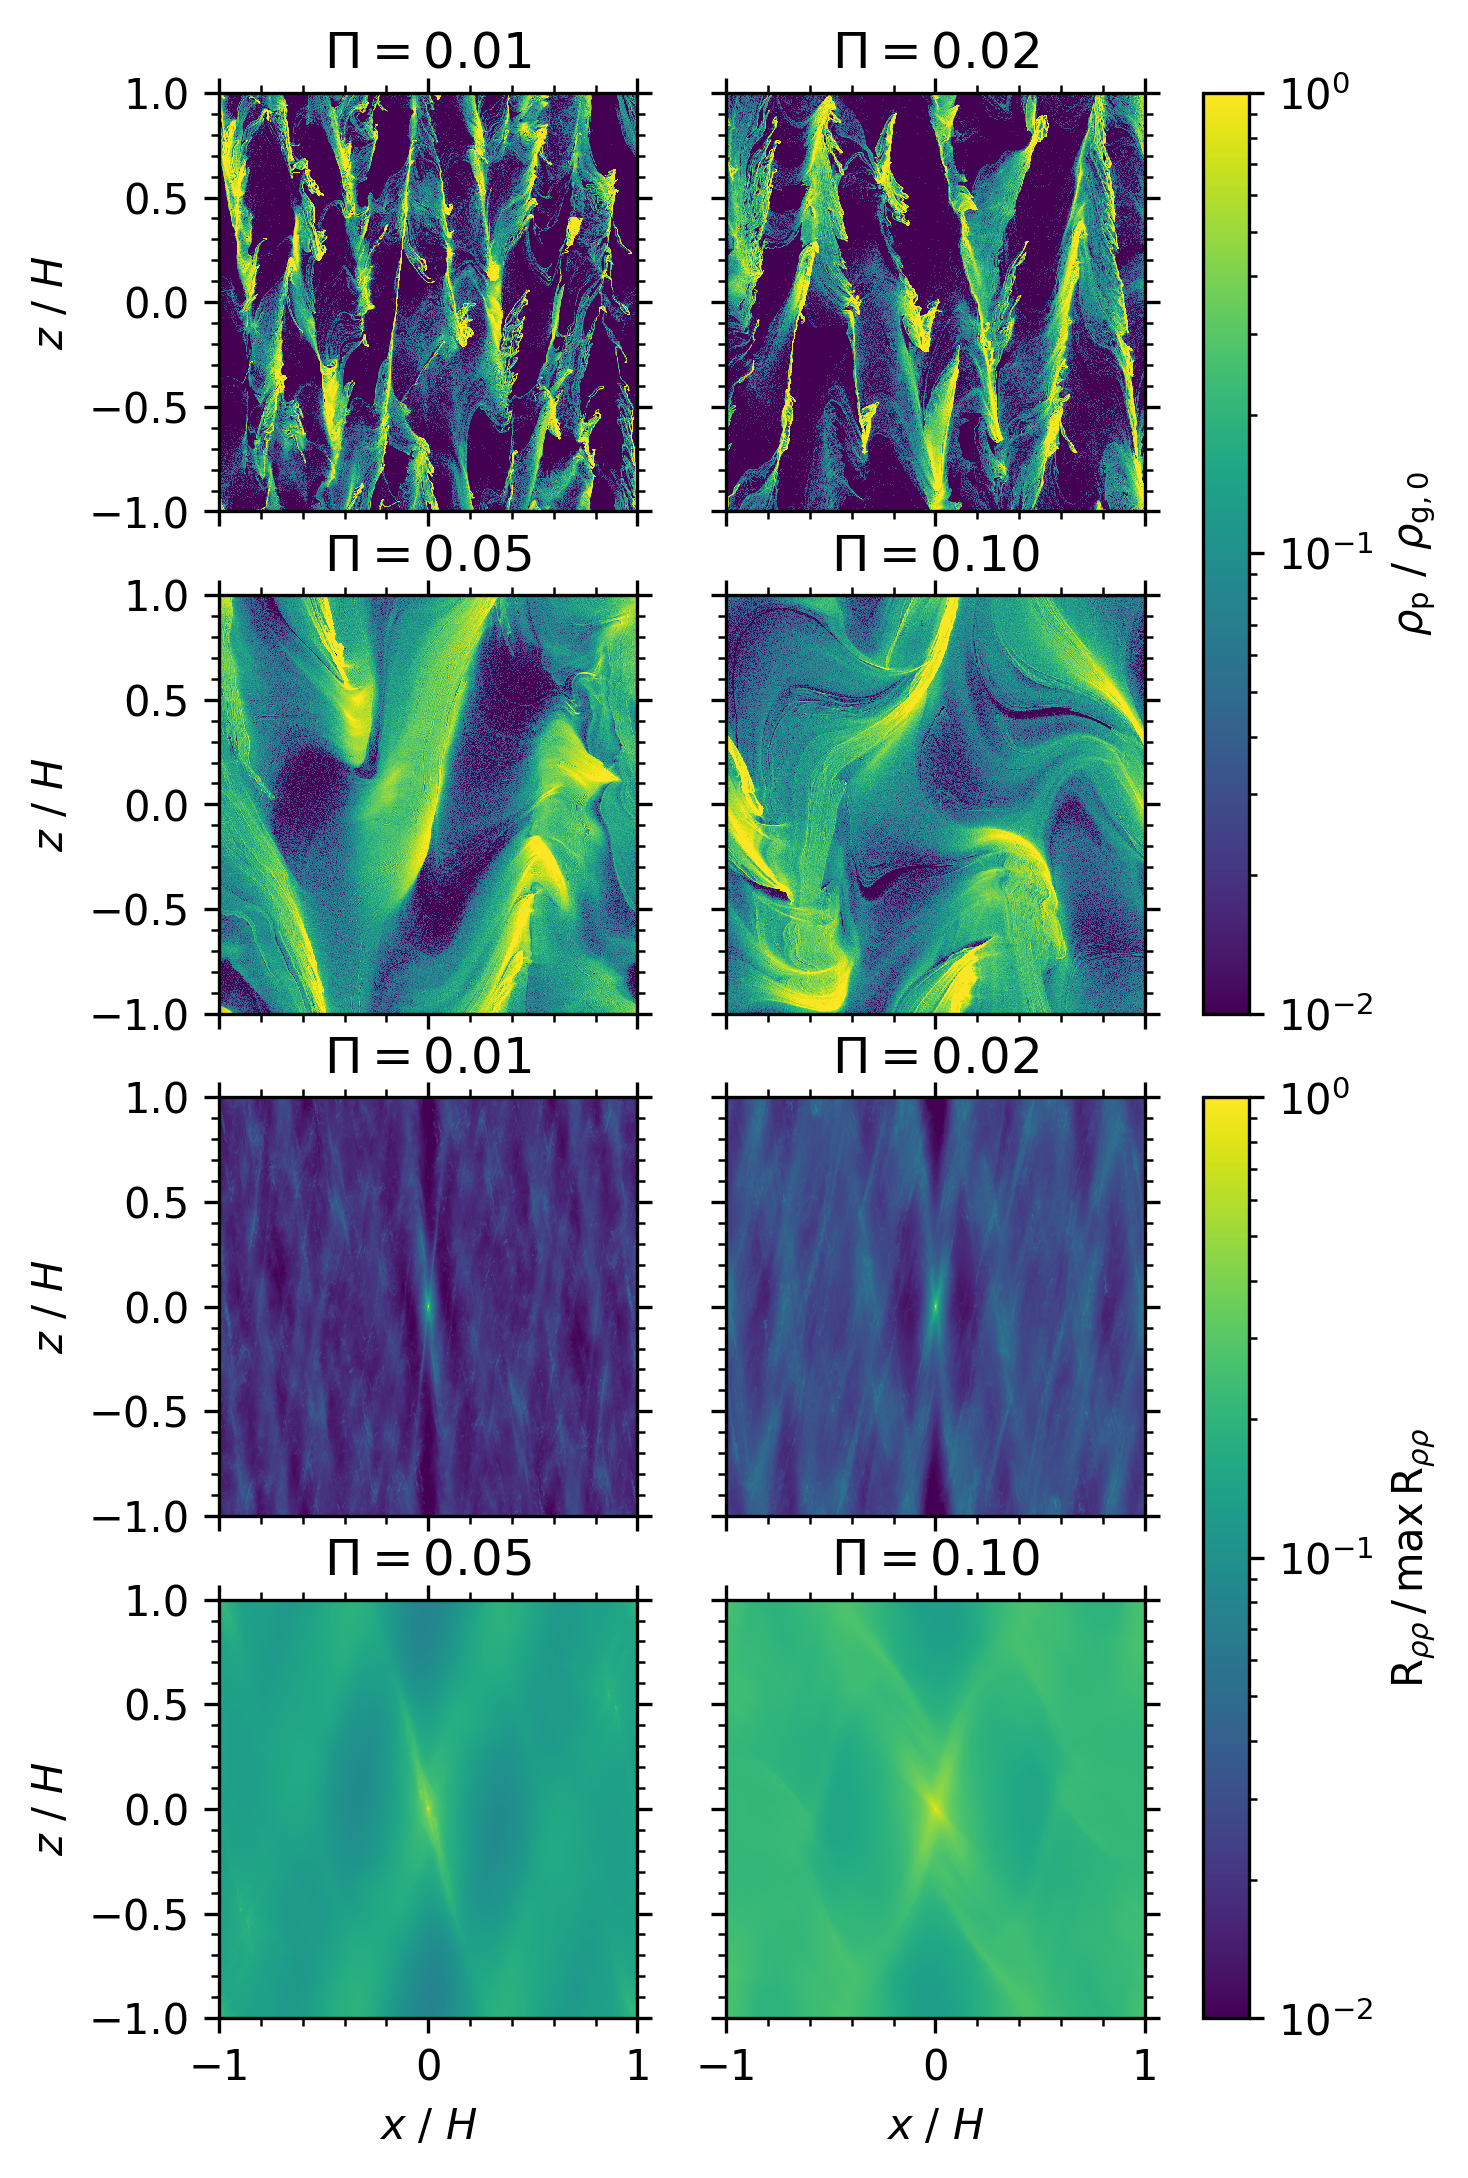

In [4]:
fig, axs = plt.subplots(4, 2, figsize=(5, 8.5), dpi=dpi)
run = 'BA'
Pis = ['0.01', '0.02', '0.05', '0.10']
res = '1024' #'2048'                             # ***FIX IN FINAL***
vmin, vmax = 1e-2, 1e0                           # CPDD > 85%; CPDD < 5%

for i,Pi in enumerate(Pis):
    path = pwd+'%s/%s/old/%s/'%(run, Pi, res)    # ***FIX IN FINAL***
    athinput = athena_read.athinput(path+'athinput.si')
    c_s = athinput['hydro']['iso_sound_speed']
    Omega = athinput['problem']['omega']
    H = c_s/Omega                                # gas scale height
    T = 2*np.pi/Omega                            # orbital period
    data = athena_read.athdf(path+'athdf/'+athinput["job"]["problem_id"]\
                             +'.out2.02000.athdf')
    xf, zf = data['x1f']/H, data['x2f']/H
    # Particle density
    clip = np.clip(data['rhop'][0], vmin, vmax)
    rhops = axs.flat[i].pcolormesh(xf, zf, clip, norm=colors.LogNorm())
    axs.flat[i].set(title=f'$\Pi={Pi:s}$')
    # Autocorrelation
    ft = fftpack.fft2(data['rhop'][0])           # Fourier transform
    ac = fftpack.ifft2(ft*np.conjugate(ft)).real # autocorrelation
    norm = ac/ac[0][0]                           # normalize
    shift = fftpack.fftshift(norm)               # center spectrum
    acs = axs.flat[i+4].pcolormesh(xf, zf, shift, norm=colors.LogNorm(vmin))
    axs.flat[i+4].set(title=f'$\Pi={Pi:s}$')

for ax in axs.flat:
    ax.minorticks_on()
    ax.set(aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.tick_params(axis='both', which='both', top=True, right=True)
    ax.label_outer()

cb_rhop = fig.colorbar(rhops, ax=axs.flat[:4])
cb_ac = fig.colorbar(acs, ax=axs.flat[4:])
cb_rhop.set_label(r'$\rho_\mathrm{p}$ / $\rho_\mathrm{g,0}$')
cb_ac.set_label(r'$\mathrm{R}_{\rho\rho}\,/\,\max\,\mathrm{R}_{\rho\rho}$')
plt.savefig('figs/autocorr.png', dpi=190, bbox_inches='tight', pad_inches=0.01)